#### Load and process data

In [1]:
using QuantumACES, StatsBase, LinearAlgebra, DataFrames, GLM, Optim
using Plots, Plots.PlotMeasures, StatsPlots, ColorSchemes, LaTeXStrings, JLD2, PrettyTables
# Set default plot parameters
pgfplotsx()
default(grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    legendfonthalign=:left, foreground_color=:black,
    background_color=:transparent, background_color_outside=:transparent,
    tex_output_standalone=true,
)
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amsmath}")
push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amssymb}")
# :tol_bright is a colourblind-friendly colourscheme
tol_bright = ColorSchemes.tol_bright
colour_series = [tol_bright[3]; tol_bright[1]; tol_bright[2]; tol_bright[4]; tol_bright[5]]
# In REVTeX, one column width is 246 pt, and the text width is 510 pt
col_width = 246.0
text_width = 510.0
aspect_ratio = 4 / 3
inches_per_pt = 1.0 / 72.27
default_dpi = 100.0
col_width_px = col_width * inches_per_pt * default_dpi
text_width_px = text_width * inches_per_pt * default_dpi
col_height_px = col_width_px / aspect_ratio
text_height_px = text_width_px / aspect_ratio
triple_height = (1 + 2 * (text_width / col_width - 1)) * col_width / aspect_ratio
triple_height_px = triple_height * inches_per_pt * default_dpi;

In [2]:
# Initialise data loading parameters
dist = 3
r_1 = 0.075 / 100
r_2 = 0.5 / 100
r_m = 2.0 / 100
total_std_log = sqrt(log(10 / 9))
seed = UInt(0)
unrotated_param = get_unrotated_param(dist)
dep_param = get_dep_param(r_1, r_2, r_m)
log_param = get_log_param(r_1, r_2, r_m, total_std_log; seed=seed)
rotated_planar = get_circuit(unrotated_param, dep_param)
dist_max = 9
dist_range = collect(3:dist_max)
dense_range = collect(2:0.025:(dist_max+1))
# Load the metadata
metadata_dict = load("data/design_metadata_$(unrotated_param.circuit_name).jld2")
@assert unrotated_param == metadata_dict["unrotated_param"]
@assert dep_param == metadata_dict["dep_param"]
dep_param_set = metadata_dict["dep_param_set"]
tuple_number_set = metadata_dict["tuple_number_set"]
repeat_numbers_set = metadata_dict["repeat_numbers_set"]
gls_tuple_number = metadata_dict["gls_tuple_number"]
gls_repeat_numbers = metadata_dict["gls_repeat_numbers"]
ols_tuple_number = metadata_dict["ols_tuple_number"]
ols_repeat_numbers = metadata_dict["ols_repeat_numbers"]
dep_idx = 14
@assert dep_param == dep_param_set[dep_idx]
merit_data_file = jldopen(
    pwd() *
    "/data/design_merit_data_$(unrotated_param.circuit_name)_$(log_param.noise_name).jld2",
)
expectation_array = merit_data_file["expectation_array"]
dep_worst_idx = findmax(vec(mean(expectation_array; dims=2)))[2]
wls_tuple_number = tuple_number_set[dep_idx]
wls_repeat_numbers = repeat_numbers_set[dep_idx]
wls_worst_tuple_number = tuple_number_set[dep_worst_idx]
wls_worst_repeat_numbers = repeat_numbers_set[dep_worst_idx]
basic_tuple_number = length(get_basic_tuple_set(rotated_planar))
basic_repeat_numbers = Int[]
# Load the data
dep_planar_scaling_wls = load_scaling(unrotated_param, dep_param, wls_tuple_number, wls_repeat_numbers, :wls)
log_planar_scaling_wls = load_scaling(unrotated_param, log_param, wls_tuple_number, wls_repeat_numbers, :wls)
dep_planar_scaling_gls = load_scaling(unrotated_param, dep_param, gls_tuple_number, gls_repeat_numbers, :gls)
dep_planar_scaling_ols = load_scaling(unrotated_param, dep_param, ols_tuple_number, ols_repeat_numbers, :ols)
dep_planar_scaling_wls_worst = load_scaling(unrotated_param, dep_param, wls_worst_tuple_number, wls_worst_repeat_numbers, :wls);
dep_planar_scaling_basic = load_scaling(unrotated_param, dep_param, basic_tuple_number, basic_repeat_numbers, :wls);

In [3]:
# Fit the scaling data
# WLS depolarising
wls_G_fit = dep_planar_scaling_wls.G_fit
wls_G_params = dep_planar_scaling_wls.G_params
wls_N_fit = dep_planar_scaling_wls.N_fit
wls_N_params = dep_planar_scaling_wls.N_params
wls_trace_fit = dep_planar_scaling_wls.trace_fit
wls_trace_params = dep_planar_scaling_wls.trace_params
wls_trace_sq_fit = dep_planar_scaling_wls.trace_sq_fit
wls_trace_sq_params = dep_planar_scaling_wls.trace_sq_params
wls_expectation_fit = dep_planar_scaling_wls.expectation_fit
wls_variance_fit = dep_planar_scaling_wls.variance_fit
# WLS lognormal
wls_expectation_fit_log = log_planar_scaling_wls.expectation_fit
wls_variance_fit_log = log_planar_scaling_wls.variance_fit
# GLS depolarising
gls_G_fit = dep_planar_scaling_gls.G_fit
gls_G_params = dep_planar_scaling_gls.G_params
gls_N_fit = dep_planar_scaling_gls.N_fit
gls_N_params = dep_planar_scaling_gls.N_params
gls_trace_fit = dep_planar_scaling_gls.trace_fit
gls_trace_params = dep_planar_scaling_gls.trace_params
gls_trace_sq_fit = dep_planar_scaling_gls.trace_sq_fit
gls_trace_sq_params = dep_planar_scaling_gls.trace_sq_params
gls_expectation_fit = dep_planar_scaling_gls.expectation_fit
gls_variance_fit = dep_planar_scaling_gls.variance_fit
@assert gls_G_params == wls_G_params
@assert gls_N_params == wls_N_params
# OLS depolarising
ols_G_fit = dep_planar_scaling_ols.G_fit
ols_G_params = dep_planar_scaling_ols.G_params
ols_N_fit = dep_planar_scaling_ols.N_fit
ols_N_params = dep_planar_scaling_ols.N_params
ols_trace_fit = dep_planar_scaling_ols.trace_fit
ols_trace_params = dep_planar_scaling_ols.trace_params
ols_trace_sq_fit = dep_planar_scaling_ols.trace_sq_fit
ols_trace_sq_params = dep_planar_scaling_ols.trace_sq_params
ols_expectation_fit = dep_planar_scaling_ols.expectation_fit
ols_variance_fit = dep_planar_scaling_ols.variance_fit
@assert ols_G_params == wls_G_params
@assert ols_N_params == wls_N_params
# Worst WLS depolarising
wls_worst_G_fit = dep_planar_scaling_wls_worst.G_fit
wls_worst_G_params = dep_planar_scaling_wls_worst.G_params
wls_worst_N_fit = dep_planar_scaling_wls_worst.N_fit
wls_worst_N_params = dep_planar_scaling_wls_worst.N_params
wls_worst_trace_fit = dep_planar_scaling_wls_worst.trace_fit
wls_worst_trace_params = dep_planar_scaling_wls_worst.trace_params
wls_worst_trace_sq_fit = dep_planar_scaling_wls_worst.trace_sq_fit
wls_worst_trace_sq_params = dep_planar_scaling_wls_worst.trace_sq_params
wls_worst_expectation_fit = dep_planar_scaling_wls_worst.expectation_fit
wls_worst_variance_fit = dep_planar_scaling_wls_worst.variance_fit
@assert wls_worst_G_params == wls_G_params
@assert wls_worst_N_params == wls_N_params
# Basic depolarising
basic_G_fit = dep_planar_scaling_basic.G_fit
basic_G_params = dep_planar_scaling_basic.G_params
basic_N_fit = dep_planar_scaling_basic.N_fit
basic_N_params = dep_planar_scaling_basic.N_params
basic_trace_fit = dep_planar_scaling_basic.trace_fit
basic_trace_params = dep_planar_scaling_basic.trace_params
basic_trace_sq_fit = dep_planar_scaling_basic.trace_sq_fit
basic_trace_sq_params = dep_planar_scaling_basic.trace_sq_params
basic_expectation_fit = dep_planar_scaling_basic.expectation_fit
basic_variance_fit = dep_planar_scaling_basic.variance_fit
@assert basic_G_params == wls_G_params
@assert basic_N_params == wls_N_params
println("The gate number as a function of code distance is: G(d) = $(wls_G_params[1]) + $(wls_G_params[2])d + $(wls_G_params[3])d^2.")
println("The gate eigenvalue number as a function of code distance is: N(d) = $(wls_N_params[1]) + $(wls_N_params[2])d + $(wls_N_params[3])d^2.")

The gate number as a function of code distance is: G(d) = 4 + -20d + 24d^2.
The gate eigenvalue number as a function of code distance is: N(d) = 54 + -180d + 144d^2.


In [4]:
# Process the WLS depolarising data
@assert dep_planar_scaling_wls.dist_range == dist_range
wls_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_wls.merit_scaling]
wls_variance_scaling = [merit.variance for merit in dep_planar_scaling_wls.merit_scaling]
wls_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_wls.merit_scaling]
wls_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_wls.merit_scaling]
wls_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_wls.merit_scaling]
wls_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_wls.merit_scaling]
wls_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_wls.merit_scaling]
wls_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_wls.merit_scaling]
wls_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_wls.merit_scaling]
# WLS data relative errors
wls_trace_fit_rel_error = (wls_trace_fit(dist_range) .- wls_trace_scaling) ./ wls_trace_scaling
wls_trace_sq_fit_rel_error = (wls_trace_sq_fit(dist_range) .- wls_trace_sq_scaling) ./ wls_trace_sq_scaling
wls_expectation_fit_rel_error = (wls_expectation_fit(dist_range) .- wls_expectation_scaling) ./ wls_expectation_scaling
wls_std_fit_rel_error = (sqrt.(wls_variance_fit(dist_range)) .- wls_stdev_scaling) ./ wls_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the WLS depolarising scaling data are:")
pretty_table(
    hcat(wls_trace_fit_rel_error, wls_trace_sq_fit_rel_error, wls_expectation_fit_rel_error, wls_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the WLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 7.9169e-10  │ -6.2409e-10 │ 3.9894e-10      │ -7.0712e-10    │
│ -5.6423e-10 │ 4.3267e-10  │ -2.8318e-10     │ 4.9818e-10     │
│ -6.6760e-11 │ 5.3857e-11  │ -3.3455e-11     │ 6.0290e-11     │
│ 5.7472e-11  │ -4.3546e-11 │ 2.8778e-11      │ -5.0498e-11    │
│ 6.0951e-11  │ -4.6567e-11 │ 3.0507e-11      │ -5.3751e-11    │
│ 2.2667e-11  │ -1.7370e-11 │ 1.1342e-11      │ -2.0016e-11    │
│ -2.9109e-11 │ 2.2078e-11  │ -1.4563e-11     │ 2.5591e-11     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [5]:
# Process the GLS depolarising data
@assert dep_planar_scaling_gls.dist_range == dist_range
gls_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_gls.merit_scaling]
gls_variance_scaling = [merit.variance for merit in dep_planar_scaling_gls.merit_scaling]
gls_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_gls.merit_scaling]
gls_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_gls.merit_scaling]
gls_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_gls.merit_scaling]
gls_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_gls.merit_scaling]
gls_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_gls.merit_scaling]
gls_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_gls.merit_scaling]
gls_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_gls.merit_scaling]
# GLS data relative errors
gls_trace_fit_rel_error = (gls_trace_fit(dist_range) .- gls_trace_scaling) ./ gls_trace_scaling
gls_trace_sq_fit_rel_error = (gls_trace_sq_fit(dist_range) .- gls_trace_sq_scaling) ./ gls_trace_sq_scaling
gls_expectation_fit_rel_error = (gls_expectation_fit(dist_range) .- gls_expectation_scaling) ./ gls_expectation_scaling
gls_std_fit_rel_error = (sqrt.(gls_variance_fit(dist_range)) .- gls_stdev_scaling) ./ gls_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the GLS depolarising scaling data are:")
pretty_table(
    hcat(gls_trace_fit_rel_error, gls_trace_sq_fit_rel_error, gls_expectation_fit_rel_error, gls_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the GLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ -1.8980e-11 │ -3.9742e-11 │ -9.4868e-12     │ -1.0380e-11    │
│ 1.3530e-11  │ 2.7721e-11  │ 6.7643e-12      │ 7.0953e-12     │
│ 1.5857e-12  │ 3.2278e-12  │ 7.9265e-13      │ 8.2100e-13     │
│ -1.3759e-12 │ -2.7669e-12 │ -6.8803e-13     │ -6.9555e-13    │
│ -1.4561e-12 │ -2.9183e-12 │ -7.2804e-13     │ -7.3104e-13    │
│ -5.4077e-13 │ -1.0816e-12 │ -2.7037e-13     │ -2.7036e-13    │
│ 6.9525e-13  │ 1.3849e-12  │ 3.4746e-13      │ 3.4488e-13     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [6]:
# Process the OLS depolarising data
@assert dep_planar_scaling_ols.dist_range == dist_range
ols_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_ols.merit_scaling]
ols_variance_scaling = [merit.variance for merit in dep_planar_scaling_ols.merit_scaling]
ols_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_ols.merit_scaling]
ols_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_ols.merit_scaling]
ols_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_ols.merit_scaling]
ols_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_ols.merit_scaling]
ols_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_ols.merit_scaling]
ols_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_ols.merit_scaling]
ols_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_ols.merit_scaling]
# OLS data relative errors
ols_trace_fit_rel_error = (ols_trace_fit(dist_range) .- ols_trace_scaling) ./ ols_trace_scaling
ols_trace_sq_fit_rel_error = (ols_trace_sq_fit(dist_range) .- ols_trace_sq_scaling) ./ ols_trace_sq_scaling
ols_expectation_fit_rel_error = (ols_expectation_fit(dist_range) .- ols_expectation_scaling) ./ ols_expectation_scaling
ols_std_fit_rel_error = (sqrt.(ols_variance_fit(dist_range)) .- ols_stdev_scaling) ./ ols_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the OLS depolarising scaling data are:")
pretty_table(
    hcat(ols_trace_fit_rel_error, ols_trace_sq_fit_rel_error, ols_expectation_fit_rel_error, ols_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the OLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 1.6243e-07  │ 3.7364e-08  │ 8.1604e-08      │ -6.2438e-08    │
│ -1.1574e-07 │ -2.8200e-08 │ -5.8001e-08     │ 4.3734e-08     │
│ -1.5194e-08 │ -1.4081e-09 │ -7.6080e-09     │ 6.8899e-09     │
│ 1.2007e-08  │ 2.7448e-09  │ 6.0091e-09      │ -4.6299e-09    │
│ 1.3048e-08  │ 2.4851e-09  │ 6.5281e-09      │ -5.2802e-09    │
│ 4.9129e-09  │ 8.4628e-10  │ 2.4576e-09      │ -2.0330e-09    │
│ -6.2382e-09 │ -1.2017e-09 │ -3.1203e-09     │ 2.5179e-09     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [7]:
# Process the worst WLS depolarising data
@assert dep_planar_scaling_wls_worst.dist_range == dist_range
wls_worst_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_variance_scaling = [merit.variance for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_wls_worst.merit_scaling]
wls_worst_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_wls_worst.merit_scaling]
# Worst WLS data relative errors
wls_worst_trace_fit_rel_error = (wls_worst_trace_fit(dist_range) .- wls_worst_trace_scaling) ./ wls_worst_trace_scaling
wls_worst_trace_sq_fit_rel_error = (wls_worst_trace_sq_fit(dist_range) .- wls_worst_trace_sq_scaling) ./ wls_worst_trace_sq_scaling
wls_worst_expectation_fit_rel_error = (wls_worst_expectation_fit(dist_range) .- wls_worst_expectation_scaling) ./ wls_worst_expectation_scaling
wls_worst_std_fit_rel_error = (sqrt.(wls_worst_variance_fit(dist_range)) .- wls_worst_stdev_scaling) ./ wls_worst_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the worst WLS depolarising scaling data are:")
pretty_table(
    hcat(wls_worst_trace_fit_rel_error, wls_worst_trace_sq_fit_rel_error, wls_worst_expectation_fit_rel_error, wls_worst_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the worst WLS depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 4.2883e-10  │ -7.9119e-10 │ 2.1629e-10      │ -6.0954e-10    │
│ -3.0559e-10 │ 5.4753e-10  │ -1.5344e-10     │ 4.2640e-10     │
│ -3.6203e-11 │ 6.7783e-11  │ -1.8147e-11     │ 5.1981e-11     │
│ 3.1131e-11  │ -5.4974e-11 │ 1.5591e-11      │ -4.3046e-11    │
│ 3.3023e-11  │ -5.8707e-11 │ 1.6531e-11      │ -4.5860e-11    │
│ 1.2283e-11  │ -2.1880e-11 │ 6.1469e-12      │ -1.7080e-11    │
│ -1.5771e-11 │ 2.7818e-11  │ -7.8905e-12     │ 2.1793e-11     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [8]:
# Process the basic design depolarising data
@assert dep_planar_scaling_basic.dist_range == dist_range
basic_expectation_scaling = [merit.expectation for merit in dep_planar_scaling_basic.merit_scaling]
basic_variance_scaling = [merit.variance for merit in dep_planar_scaling_basic.merit_scaling]
basic_stdev_scaling = [sqrt(merit.variance) for merit in dep_planar_scaling_basic.merit_scaling]
basic_trace_scaling = [sum(merit.eigenvalues) for merit in dep_planar_scaling_basic.merit_scaling]
basic_trace_sq_scaling = [sum(merit.eigenvalues .^ 2) for merit in dep_planar_scaling_basic.merit_scaling]
basic_experiment_number_scaling = [merit.experiment_number for merit in dep_planar_scaling_basic.merit_scaling]
basic_cond_num_scaling = [merit.cond_num for merit in dep_planar_scaling_basic.merit_scaling]
basic_pinv_norm_scaling = [merit.pinv_norm for merit in dep_planar_scaling_basic.merit_scaling]
basic_eigenvalues_scaling = [merit.eigenvalues for merit in dep_planar_scaling_basic.merit_scaling]
# Trivial design data relative errors
basic_trace_fit_rel_error = (basic_trace_fit(dist_range) .- basic_trace_scaling) ./ basic_trace_scaling
basic_trace_sq_fit_rel_error = (basic_trace_sq_fit(dist_range) .- basic_trace_sq_scaling) ./ basic_trace_sq_scaling
basic_expectation_fit_rel_error = (basic_expectation_fit(dist_range) .- basic_expectation_scaling) ./ basic_expectation_scaling
basic_std_fit_rel_error = (sqrt.(basic_variance_fit(dist_range)) .- basic_stdev_scaling) ./ basic_stdev_scaling
# Print the relative errors of the fit
header = [
    "tr(Σ)"
    "tr(Σ²)"
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the basic design depolarising scaling data are:")
pretty_table(
    hcat(basic_trace_fit_rel_error, basic_trace_sq_fit_rel_error, basic_expectation_fit_rel_error, basic_std_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the basic design depolarising scaling data are:
┌─────────────┬─────────────┬─────────────────┬────────────────┐
│ tr(Σ)       │ tr(Σ²)      │ Figure of merit │ NRMSE st. dev. │
├─────────────┼─────────────┼─────────────────┼────────────────┤
│ 5.2919e-15  │ 3.8328e-14  │ 2.4964e-15      │ 1.6599e-14     │
│ -1.5646e-16 │ 3.1876e-15  │ 0.0000e+00      │ 1.5824e-15     │
│ -1.4784e-15 │ -5.4072e-15 │ -7.0507e-16     │ -2.0338e-15    │
│ -9.7490e-16 │ -5.1985e-15 │ -4.6894e-16     │ -2.0712e-15    │
│ -1.0363e-15 │ -2.3511e-15 │ -4.6819e-16     │ -8.1592e-16    │
│ 1.2877e-16  │ 1.9373e-16  │ 1.1692e-16      │ 0.0000e+00     │
│ 0.0000e+00  │ 1.9419e-15  │ -1.1682e-16     │ 8.5360e-16     │
└─────────────┴─────────────┴─────────────────┴────────────────┘


In [9]:
# Process the WLS lognormal data
@assert log_planar_scaling_wls.dist_range == dist_range
repetitions = length.(log_planar_scaling_wls.expectation_scaling)
@assert repetitions == length.(log_planar_scaling_wls.variance_scaling)
wls_expectation_scaling_log = log_planar_scaling_wls.expectation_scaling
wls_mean_expectation_scaling_log = mean.(wls_expectation_scaling_log)
wls_std_expectation_scaling_log = std.(wls_expectation_scaling_log)
wls_sem_expectation_scaling_log = wls_std_expectation_scaling_log ./ sqrt.(repetitions)
wls_stdev_scaling_log = [sqrt.(variances) for variances in log_planar_scaling_wls.variance_scaling]
wls_mean_stdev_scaling_log = mean.(wls_stdev_scaling_log)
wls_std_stdev_scaling_log = std.(wls_stdev_scaling_log)
wls_sem_stdev_scaling_log = wls_std_stdev_scaling_log ./ sqrt.(repetitions)
# WLS data relative errors
wls_expectation_log_fit_rel_error = (wls_expectation_fit_log(dist_range) .- wls_mean_expectation_scaling_log) ./ wls_mean_expectation_scaling_log
wls_std_log_fit_rel_error = (sqrt.(wls_variance_fit_log(dist_range)) .- wls_mean_stdev_scaling_log) ./ wls_mean_stdev_scaling_log
# Print the relative errors of the fit
header = [
    "Figure of merit"
    "NRMSE st. dev."
]
println("The relative errors of the fits for the WLS mean of the lognormal scaling data are:")
pretty_table(
    hcat(wls_expectation_log_fit_rel_error, wls_std_log_fit_rel_error);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.4e"),
)

The relative errors of the fits for the WLS mean of the lognormal scaling data are:
┌─────────────────┬────────────────┐
│ Figure of merit │ NRMSE st. dev. │
├─────────────────┼────────────────┤
│ -1.3154e-04     │ 3.4967e-04     │
│ 5.6929e-04      │ 3.3777e-04     │
│ -5.1459e-04     │ -1.8189e-04    │
│ 3.0333e-04      │ -1.6566e-05    │
│ -7.5365e-04     │ 6.2737e-05     │
│ 2.0496e-04      │ 1.3457e-04     │
│ 3.2362e-04      │ 2.4658e-04     │
└─────────────────┴────────────────┘


#### Plotting the figure of merit as a function of the code distance

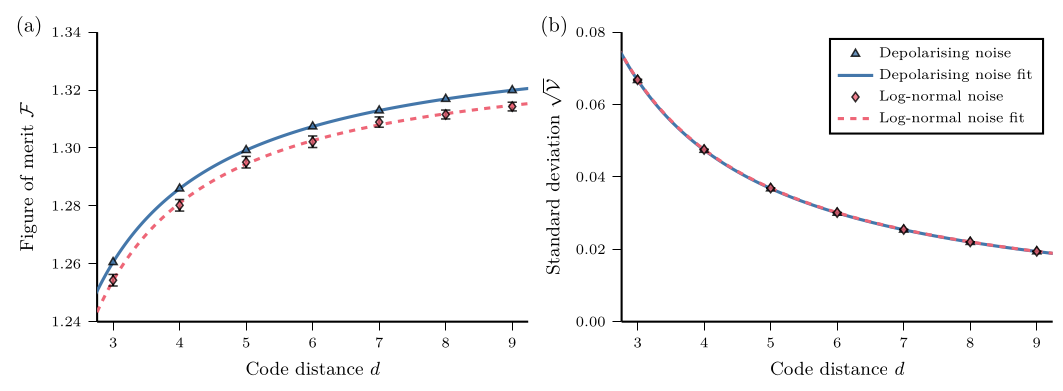

In [10]:
# Plot the figure of merit and NRMSE standard deviation as a function of code distance, including fits, for depolarising and lognormal noise
pad = 0.08
x_min = 3
x_int = 1
x_max = dist_max
default(grid=false, fillalpha=0.5, tick_direction=:out, margins=0px,
    titlefontsize=10, guidefontsize=9, tickfontsize=7, legendfontsize=7,
    legendfonthalign=:left, foreground_color=:black,
    background_color=:transparent, background_color_outside=:transparent,
    tex_output_standalone=true,
    palette=reverse(colour_series[1:4]), markersize=3, markeralpha=0.8,
    xlims=(x_min, x_max), xticks=x_min:x_int:x_max,
    xguide=L"\textrm{Code distance }d", xwiden=1 + pad,
    legend=:topright,
)
# Figure of merit plot
y_min = 1.24
y_max = 1.34
y_int = 0.02
expectation_plot = scatter(dist_range, wls_expectation_scaling;
    ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Figure of merit }\mathcal{F}",
    markershape=:utriangle, color=colour_series[2], label="Depolarising noise",
    legend=false,
)
plot!(dense_range, wls_expectation_fit(dense_range);
    linestyle=:solid,
    linewidth=1.5,
    color=colour_series[2],
    label="Depolarising noise fit",
)
scatter!(dist_range, wls_mean_expectation_scaling_log;
    yerror=2 * wls_sem_expectation_scaling_log,
    markershape=:diamond,
    color=colour_series[3],
    label="Log-normal noise",
)
plot!(dense_range, wls_expectation_fit_log(dense_range);
    linestyle=:dash,
    linewidth=1.5,
    color=colour_series[3],
    label="Log-normal noise fit",
    extra_kwargs=:plot, add=raw"
    \node[anchor=south west] at (0.0-1.5,0.0-0.2) {(a)};
    \node[anchor=south west] at (8.88-1.5,0.0-0.2) {(b)};
")
# \node at (0.0,0.0) {o};
# \node at (8.88,0.0) {o};
# Standard deviation plot
y_min = 0.0
y_max = 0.08
y_int = 0.02
stdev_plot = scatter(dist_range, wls_stdev_scaling;
    ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Standard deviation }\sqrt{\mathcal{V}}",
    markershape=:utriangle,
    color=colour_series[2],
    label="Depolarising noise",
)
plot!(dense_range, sqrt.(wls_variance_fit(dense_range));
    linestyle=:solid,
    linewidth=1.5,
    color=colour_series[2],
    label="Depolarising noise fit",
)
scatter!(dist_range, wls_mean_stdev_scaling_log;
    yerror=2 * wls_sem_stdev_scaling_log,
    markershape=:diamond,
    color=colour_series[3],
    label="Log-normal noise",
)
plot!(dense_range, sqrt.(wls_variance_fit_log(dense_range));
    linestyle=:dash,
    linewidth=1.5,
    color=colour_series[3],
    label="Log-normal noise fit",
)
# Combined plot
combined_plot = plot(expectation_plot, stdev_plot; layout=(1, 2), size=(text_width_px * 0.991, col_height_px))
savefig(combined_plot, pwd() * "/figures/nrmse_scaling_$(unrotated_param.circuit_name).tex")
display(combined_plot)

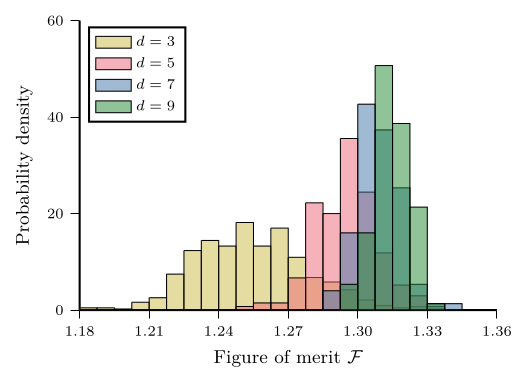

In [11]:
# Histogram of the figure of merit across instances of lognormal noise as a function of code distance
log_hist = histogram(
    wls_expectation_scaling_log[[1; 3; 5; 7]];
    labels=hcat([L"d = %$(d)" for d in dist_range[[1; 3; 5; 7]]]...),
    xlims=(1.18, 1.36), xticks=1.18:0.03:1.36, xwiden=1,
    xguide=L"\textrm{Figure of merit }\mathcal{F}",
    ylims=(0, 60), yticks=0:20:60,
    yguide="Probability density",
    bins=1.18:0.0075:1.36, normalize=:pdf,
    linewidth=0.5, legend=:topleft,
    size=(col_width_px, col_height_px),
)
plot_xlims = xlims(log_hist)
@assert plot_xlims[1] < minimum(minimum(wls_expectation_scaling_log)) && plot_xlims[2] > maximum(maximum(wls_expectation_scaling_log))
savefig(log_hist, pwd() * "/figures/nrmse_scaling_hist_$(unrotated_param.circuit_name).tex")
display(log_hist)

#### Confirming fit parameterisation with the corrected Akaike information criterion

In [12]:
# Compare the AICc of different fit parameterisations
wls_trace_data = DataFrame(y=wls_trace_scaling, x=dist_range)
wls_trace_constant_model = lm(@formula(y ~ 1), wls_trace_data)
wls_trace_linear_model = lm(@formula(y ~ 1 + x), wls_trace_data)
wls_trace_quadratic_model = lm(@formula(y ~ 1 + x + x^2), wls_trace_data)
wls_trace_cubic_model = lm(@formula(y ~ 1 + x + x^2 + x^3), wls_trace_data)
wls_trace_quartic_model = lm(@formula(y ~ 1 + x + x^2 + x^3 + x^4), wls_trace_data)
wls_trace_aicc = [aicc(wls_trace_constant_model); aicc(wls_trace_linear_model); aicc(wls_trace_quadratic_model); aicc(wls_trace_cubic_model); aicc(wls_trace_quartic_model)]
wls_trace_sq_data = DataFrame(y=wls_trace_sq_scaling, x=dist_range)
wls_trace_sq_constant_model = lm(@formula(y ~ 1), wls_trace_sq_data)
wls_trace_sq_linear_model = lm(@formula(y ~ 1 + x), wls_trace_sq_data)
wls_trace_sq_quadratic_model = lm(@formula(y ~ 1 + x + x^2), wls_trace_sq_data)
wls_trace_sq_cubic_model = lm(@formula(y ~ 1 + x + x^2 + x^3), wls_trace_sq_data)
wls_trace_sq_quartic_model = lm(@formula(y ~ 1 + x + x^2 + x^3 + x^4), wls_trace_sq_data)
wls_trace_sq_aicc = [aicc(wls_trace_sq_constant_model); aicc(wls_trace_sq_linear_model); aicc(wls_trace_sq_quadratic_model); aicc(wls_trace_sq_cubic_model); aicc(wls_trace_sq_quartic_model)]
# Print AICc
header = [
    "Model"
    "AICc"
]
model_types = ["Constant"; "Linear"; "Quadratic"; "Cubic"; "Quartic"]
println("The corrected Akaike information criteria of polynomial fits of tr(Σ) are:")
pretty_table(
    hcat(model_types, wls_trace_aicc);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.2f"),
)
println("The corrected Akaike information criteria of polynomial fits of tr(Σ²) are:")
pretty_table(
    hcat(model_types, wls_trace_sq_aicc);
    header=header,
    alignment=:l,
    formatters=ft_printf("%.2f"),
)
println("The quadratic model is best according to the AICc in both instances.")

The corrected Akaike information criteria of polynomial fits of tr(Σ) are:
┌───────────┬─────────┐
│ Model     │ AICc    │
├───────────┼─────────┤
│ Constant  │ 147.46  │
│ Linear    │ 129.07  │
│ Quadratic │ -148.83 │
│ Cubic     │ -115.30 │
│ Quartic   │ Inf     │
└───────────┴─────────┘
The corrected Akaike information criteria of polynomial fits of tr(Σ²) are:
┌───────────┬─────────┐
│ Model     │ AICc    │
├───────────┼─────────┤
│ Constant  │ 175.90  │
│ Linear    │ 157.71  │
│ Quadratic │ -124.48 │
│ Cubic     │ -91.17  │
│ Quartic   │ Inf     │
└───────────┴─────────┘
The quadratic model is best according to the AICc in both instances.


#### Plotting and displaying various quantities as a function of code distance across the different designs

In [13]:
# Initialise data
plot_labels = [L"\mathrm{GLS}", L"\mathrm{WLS}", L"\mathrm{WLS}^*", L"\mathrm{OLS}"]
labels = ["GLS", "WLS", "WLS (misoptim.)", "OLS", "Basic (WLS)"]
marker_shapes = [:diamond, :utriangle, :dtriangle, :pentagon]
expectation_set = [gls_expectation_scaling, wls_expectation_scaling, wls_worst_expectation_scaling, ols_expectation_scaling, basic_expectation_scaling]
expectation_fit_set = [gls_expectation_fit, wls_expectation_fit, wls_worst_expectation_fit, ols_expectation_fit, basic_expectation_fit]
stdev_set = [gls_stdev_scaling, wls_stdev_scaling, wls_worst_stdev_scaling, ols_stdev_scaling, basic_stdev_scaling]
stdev_fit_set = [gls_variance_fit, wls_variance_fit, wls_worst_variance_fit, ols_variance_fit, basic_variance_fit]
experiment_number_set = [gls_experiment_number_scaling, wls_experiment_number_scaling, wls_worst_experiment_number_scaling, ols_experiment_number_scaling, basic_experiment_number_scaling]
cond_num_set = [gls_cond_num_scaling, wls_cond_num_scaling, wls_worst_cond_num_scaling, ols_cond_num_scaling, basic_cond_num_scaling]
pinv_norm_set = [gls_pinv_norm_scaling, wls_pinv_norm_scaling, wls_worst_pinv_norm_scaling, ols_pinv_norm_scaling, basic_pinv_norm_scaling];

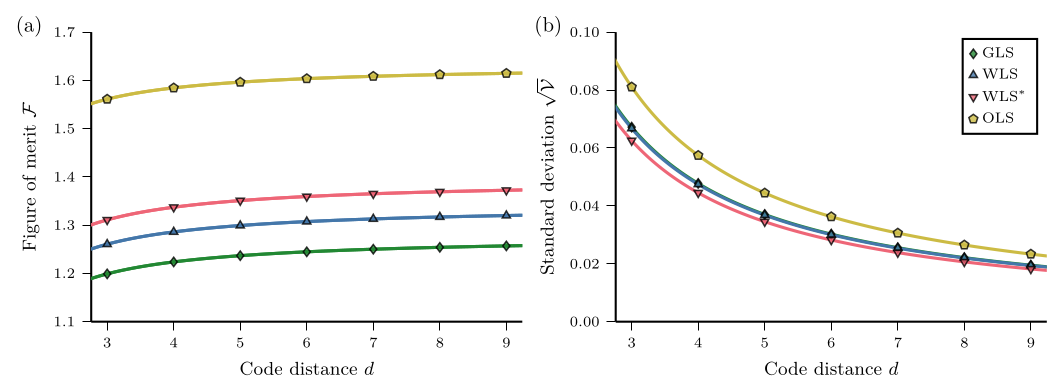

In [14]:
# Plot the figure of merit and NRMSE standard deviation as a function of code distance, including fits, for depolarising noise and a range of designs
# Figure of merit plot
y_min = 1.1
y_max = 1.7
y_int = 0.1
expectation_set_plot = plot(; ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Figure of merit }\mathcal{F}",
    legend=false,
)
for idx in 1:4
    scatter!(dist_range, expectation_set[idx];
        markershape=marker_shapes[idx],
        color=colour_series[idx],
    )
    plot!(dense_range, expectation_fit_set[idx](dense_range);
        linestyle=:solid, linewidth=1.5,
        color=colour_series[idx],
    )
    if idx == 4
        plot!(dense_range, expectation_fit_set[idx](dense_range);
            linestyle=:solid, linewidth=1.5,
            color=colour_series[idx],
            extra_kwargs=:plot, add=raw"
            \node[anchor=south west] at (0.0-1.5+0.1,0.0-0.2) {(a)};
            \node[anchor=south west] at (8.88-1.5,0.0-0.2) {(b)};
        ")
        # \node at (0.0,0.0) {o};
        # \node at (8.88,0.0) {o};
    else
        plot!(dense_range, expectation_fit_set[idx](dense_range);
            linestyle=:solid, linewidth=1.5,
            color=colour_series[idx],
        )
    end
end
# Variance plot
y_min = 0.0
y_max = 0.10
y_int = 0.02
stdev_set_plot = plot(; ylims=(y_min, y_max), yticks=y_min:y_int:y_max,
    yguide=L"\textrm{Standard deviation }\sqrt{\mathcal{V}}",
)
for idx in 1:4
    scatter!(dist_range, stdev_set[idx];
        markershape=marker_shapes[idx],
        color=colour_series[idx],
        label=plot_labels[idx],
    )
    plot!(dense_range, sqrt.(stdev_fit_set[idx](dense_range));
        linestyle=:solid, linewidth=1.5,
        color=colour_series[idx],
        label=nothing,
    )
end
# Combined plot
combined_set_plot = plot(expectation_set_plot, stdev_set_plot; size=(text_width_px * 0.991, col_height_px))
savefig(combined_set_plot, pwd() * "/figures/nrmse_scaling_$(unrotated_param.circuit_name)_combined.tex")
display(combined_set_plot)

In [15]:
# Tables of the figure of merit and NRMSE standard deviation
println("The figures of merit for depolarising noise across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; expectation_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)
println("The NRMSE standard deviations for depolarising noise across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; stdev_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)

The figures of merit for depolarising noise across a range of designs and code distances are:
┌───┬────────┬────────┬─────────────────┬────────┬─────────────┐
│ d │ GLS    │ WLS    │ WLS (misoptim.) │ OLS    │ Basic (WLS) │
├───┼────────┼────────┼─────────────────┼────────┼─────────────┤
│ 3 │ 1.1990 │ 1.2605 │ 1.3109          │ 1.5611 │ 3.7357      │
│ 4 │ 1.2238 │ 1.2860 │ 1.3371          │ 1.5844 │ 3.7644      │
│ 5 │ 1.2368 │ 1.2992 │ 1.3509          │ 1.5964 │ 3.7791      │
│ 6 │ 1.2448 │ 1.3074 │ 1.3593          │ 1.6036 │ 3.7880      │
│ 7 │ 1.2502 │ 1.3129 │ 1.3651          │ 1.6085 │ 3.7941      │
│ 8 │ 1.2541 │ 1.3169 │ 1.3692          │ 1.6120 │ 3.7984      │
│ 9 │ 1.2570 │ 1.3199 │ 1.3723          │ 1.6146 │ 3.8016      │
└───┴────────┴────────┴─────────────────┴────────┴─────────────┘
The NRMSE standard deviations for depolarising noise across a range of designs and code distances are:
┌───┬────────┬────────┬─────────────────┬────────┬─────────────┐
│ d │ GLS    │ WLS    │

In [16]:
# Table of experiment numbers
println("The experiment numbers across a range of designs and code distances are:")
pretty_table(hcat([[dist_range]; experiment_number_set]...); header=["d"; labels], alignment=:l)
println("All of these values are constant with code distance.")

The experiment numbers across a range of designs and code distances are:
┌───┬─────┬─────┬─────────────────┬─────┬─────────────┐
│ d │ GLS │ WLS │ WLS (misoptim.) │ OLS │ Basic (WLS) │
├───┼─────┼─────┼─────────────────┼─────┼─────────────┤
│ 3 │ 906 │ 870 │ 1158            │ 456 │ 156         │
│ 4 │ 906 │ 870 │ 1158            │ 456 │ 156         │
│ 5 │ 906 │ 870 │ 1158            │ 456 │ 156         │
│ 6 │ 906 │ 870 │ 1158            │ 456 │ 156         │
│ 7 │ 906 │ 870 │ 1158            │ 456 │ 156         │
│ 8 │ 906 │ 870 │ 1158            │ 456 │ 156         │
│ 9 │ 906 │ 870 │ 1158            │ 456 │ 156         │
└───┴─────┴─────┴─────────────────┴─────┴─────────────┘
All of these values are constant with code distance.


In [17]:
# Table of condition numbers and pseudoinverse norms
println("The design matrix condition numbers across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; cond_num_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.2f"))
)
println("The design matrix pseudoinverse norms across a range of designs and code distances are:")
pretty_table(
    hcat([[dist_range]; pinv_norm_set]...);
    header=["d"; labels],
    alignment=:l,
    formatters=(ft_printf("%i", 1), ft_printf("%.4f"))
)
println("""
The condition numbers and pseudoinverse norms do not substantially change with code distance.
The optimised WLS design has a worse pseudoinverse norm than the worst-performing WLS design optimised for different noise parameters, despite performing better on the noise parameters of interest.""")

The design matrix condition numbers across a range of designs and code distances are:
┌───┬────────┬────────┬─────────────────┬───────┬─────────────┐
│ d │ GLS    │ WLS    │ WLS (misoptim.) │ OLS   │ Basic (WLS) │
├───┼────────┼────────┼─────────────────┼───────┼─────────────┤
│ 3 │ 149.01 │ 151.45 │ 290.95          │ 16.65 │ 28.67       │
│ 4 │ 149.25 │ 151.63 │ 291.32          │ 16.71 │ 29.78       │
│ 5 │ 149.48 │ 151.82 │ 291.67          │ 16.74 │ 30.24       │
│ 6 │ 149.70 │ 152.01 │ 292.00          │ 16.75 │ 30.48       │
│ 7 │ 149.88 │ 152.19 │ 292.28          │ 16.76 │ 30.62       │
│ 8 │ 150.02 │ 152.34 │ 292.51          │ 16.76 │ 30.71       │
│ 9 │ 150.15 │ 152.47 │ 292.71          │ 16.76 │ 30.76       │
└───┴────────┴────────┴─────────────────┴───────┴─────────────┘
The design matrix pseudoinverse norms across a range of designs and code distances are:
┌───┬────────┬────────┬─────────────────┬────────┬─────────────┐
│ d │ GLS    │ WLS    │ WLS (misoptim.) │ OLS    │ Basic 